<a href="https://colab.research.google.com/github/sshersh/ECE-474-Bayes-ML/blob/main/Proj_2_Linear_Reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [169]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib

This project explores two methods of Bayes linear regression, namely parameter distribution and predictive distribution. Figures 3.7 and 3.8 in **Pattern Recognition and Machine Learning** by Bishop are reproduced. 
In the first example, the hyperparameters of a linear model are learned based on a dataset created from a linear function + noise. The multivariate distribution of the parameters is then plotted, as well as samples from the distribution in x-y space.
In the second example, a posterior is formed for the target directly. The dataset is sampled from a sine function + noise, and the predictive distribution method is used to train the model. The results are plotted directly in x-y space.

In [170]:
# P3.7
# Sample data from the fn f(x, a) = a0 + a1*x

a_0 = 0.2
a_1 = 0.3
w = [a_0, a_1]
beta = 25
num_samples = 20

# sample x from U(-1, 1)
x = 2*np.random.rand(num_samples,1) - 1

# form the data vector
y = a_0*np.ones((num_samples,1)) + a_1*x

# add gaussian noise to get the targets
t = y + np.random.normal(0, 1/beta, size=(num_samples,1))
pts = np.hstack((x,t))

In [171]:
def update_mean(s_n, s_0_inv, design_mat, target, beta):
  """
  Do a Bayesian update of the mean of weights with m samples following eqn 3.53 in the text

  @param design_mat   mx2 array
  @param s_n:         2x2 array
  @param s_0_inv:     2x2 array
  @param m_0:         
  @param target:      mx1 array
  @param beta:        scalar
  """
  return beta * s_n @ design_mat.T @ target

def update_cov(design_mat, s_0_inv, beta):
  """
  Do a Bayesian update of the covariance matrix following eqn 3.54 in the text

  @param design_mat:  mx2 array
  @param s_0_inv:     2x2 array
  @param beta:        scalar
  """
  return np.linalg.inv(s_0_inv + beta* (design_mat.T @ design_mat))

def update_phi(dep_var):
  """
  Evaluate basis function for given values of x

  @param  mx1 array
  @returns mx2 array
  """ 
  # basis function is simple linear fn of x
  num_samples = len(dep_var)
  return np.hstack((np.ones((num_samples,1)), dep_var))

def update_closed_form(x, t, s_0_inv, beta):
  """
  Use closed form MAP soln for normal priors derived in text

  @param  x [mx1 array]     observables
  @param  t [mx1 array]     labels
  @param  s_0_inv [2x2 array] precision matrix
  @param  beta [scalar]     precision of the additive noise

  @returns  new_post
  """
  phi_n = update_phi(x)
  s_n = update_cov(phi_n, s_0_inv, beta)
  m_n = update_mean(s_n, s_0_inv, phi_n, t, beta)
  return multivariate_normal(m_n[:,0], s_n)

def gen_likelihood(x, t, beta):
  """ Generate likelihood function of weights given observable and label vectors

  @param  x [scalar]
  @param  t [scalar]
  @param  beta [scalar]
  """
  phi = update_phi([x])
  const_term = (-1/2)*np.log(2*np.pi) + (1/2)*np.log(beta**2) 

  def log_likelihood(w):
    """ Log Likelihood function of weights, based on assumption of IID samples
    @param w  1x2 array of weights 
    """
    return -((beta**2)/2)*np.sum((t - phi @ w)**2) + const_term
  return log_likelihood

def plot_heatmap(ax, w, post):
  """ Plot the posterior distribution

  @param w  1x2 array of weights
  """
  X, Y = np.mgrid[-1:1:.01, -1:1:.01]
  pos = np.dstack((X, Y)) 
  ax.set_xlabel(r"$a_0$")
  ax.set_ylabel(r"$a_1$")
  ax.contourf(X, Y, post.pdf(pos), 50, cmap="jet")
  ax.plot(w[0], w[1], 'w+')

def plot_likelihood(ax, w, log_likelihood):
  """ Plot the likelihood function over w1 and w2
  @param w              1x2 array of weights
  @param log_likelihood
  """
  W1, W2 = np.mgrid[-1:1:.05, -1:1:.05]
  surf = np.zeros(W1.shape)
  coords = np.dstack((W1, W2))
  for ii in np.arange(W1.shape[0]):
    for jj in np.arange(W1.shape[1]):
      surf[ii,jj] = log_likelihood(coords[ii,jj])

  ax.set_xlabel(r"$a_0$", )
  ax.set_ylabel(r"$a_1$")
  ax.contourf(W1, W2, surf, 50, cmap="jet")
  ax.plot(w[0], w[1], 'w+')

def plot_line(ax, coeffs):
  x = np.linspace(-1, 1, 100)
  y = np.ones(100)*coeffs[0] + coeffs[1]*x
  ax.plot(x, y, 'r')

def xy_plot(ax, post, pts=None):
  if pts is not None:
    ax.scatter(pts[:,0], pts[:,1], facecolors='none', edgecolors='b')

  coeffs = post.rvs(5)
  for w in coeffs:
    plot_line(ax, w)
  
  ax.set_xlabel("x")
  ax.set_ylabel("y")


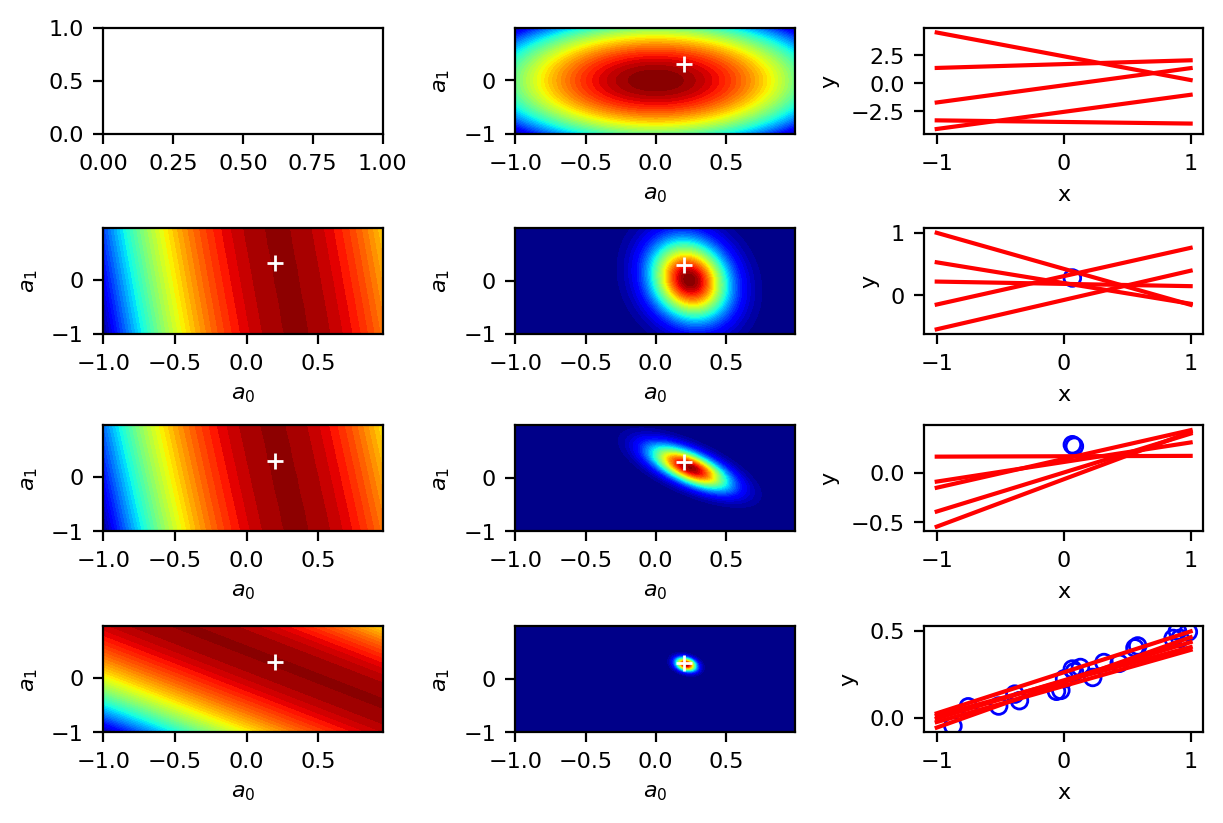

In [172]:
matplotlib.rcParams.update({'font.size': 8})

# start with some arbitrary precision parameter for the prior
alpha = 4

# choose an initial mean and precision matrix
m_0 = np.array([0, 0])
s_0_inv = alpha*np.eye(2)

# construct the prior
prior = multivariate_normal(m_0, s_0_inv)
likelihood_1 = gen_likelihood(x[0], t[0], beta)
likelihood_2 = gen_likelihood(x[1], t[1], beta)
likelihood_20 = gen_likelihood(x[19], t[19], beta)
post_1 = update_closed_form([x[0]], [t[0]], s_0_inv, beta)
post_2 = update_closed_form(x[1:3], t[1:3], s_0_inv, beta)
post_20 = update_closed_form(x[1:21], t[1:21], s_0_inv, beta)
fig, axs = plt.subplots(4, 3, dpi=200, constrained_layout=True)
plot_likelihood(axs[1,0], w, likelihood_1)
plot_likelihood(axs[2,0], w, likelihood_2)
plot_likelihood(axs[3,0], w, likelihood_20)
plot_heatmap(axs[0,1], w, prior)
plot_heatmap(axs[1,1], w, post_1)
plot_heatmap(axs[2,1], w, post_2)
plot_heatmap(axs[3,1], w, post_20)
xy_plot(axs[0,2], prior)
xy_plot(axs[1,2], post_1, np.array([pts[0]]))
xy_plot(axs[2,2], post_2, pts[0:2])
xy_plot(axs[3,2], post_20, pts)

In [173]:
# P3.8
# Sample data from the fn f(x, a) = sin(2*pi*x)
beta = 10
num_samples = 25

# sample x from U(-1, 1)
x = 2*np.random.rand(num_samples,1) - 1

# form the data vector
y = np.sin(2*np.pi*x)

# add gaussian noise to get the targets
t = y + np.random.normal(0, 1/beta, size=(num_samples,1))
pts = np.hstack((x,t))

In [174]:
# scale parameter
s = 0.15

def form_design_matrix(x):
  """Form design matrix with gaussian basis functions
  @param x  [1XN array] the argument

  @returns  [Nx9 array] design matrix  
  """

  # the position parameters for each basis function
  mu = np.linspace(-1, 1, 9)

  MU, X = np.meshgrid(mu, x)
  return np.exp(-np.square((X - MU)/(np.sqrt(2)*s)))

def phi(x_pt):
  """ Basis function evaluated at a single x point
  """
  mu = np.linspace(-1, 1, 9)
  return np.exp(-np.square((x_pt - mu)/(np.sqrt(2)*s)))

def form_post(x, t, s_0_inv, beta):
  """The equivalent of update_closed_form in the last example.
  Uses Eq 3.58 in the text. Now the posterior is a function of x

  @param  x [mx1 array]     data
  @param  t [mx1 array]     labels
  @param  s_0_inv [2x2 array] precision matrix
  @param  beta [scalar]     precision of the additive noise

  @returns  new posterior distribution as fn of x
  """
  phi_n = form_design_matrix(x)
  s_n = update_cov(phi_n, s_0_inv, beta)
  m_n = update_mean(s_n, s_0_inv, phi_n, t, beta)
  
  def post(x_pt):
    """ Posterior as a fn of x
    
    @returns (mean, covariance matrix, post)
    """
    phi_vec = phi(x_pt)
    mean = m_n.T @ phi_vec
    var = 1/beta + phi_vec.T @ s_n @ phi_vec
    return mean, var, norm(mean, var)
  return post

def plot_pred(ax, post):
  x_pts = np.linspace(-1, 1, 500)
  targ = np.zeros(len(x_pts))
  lower = np.zeros(len(x_pts))
  upper = np.zeros(len(x_pts))
  for ii in range(len(x_pts)):
    targ[ii], var, _ = post(x_pts[ii])
    lower[ii] = targ[ii] - var
    upper[ii] = targ[ii] + var
  ax.plot(x_pts, targ, 'r')   
  ax.fill_between(x_pts, lower, upper, color='lightcoral')

def plot_38(ax, post, pts):
  plot_pred(ax, post)

  # plot the dataset
  ax.scatter(pts[:,0], pts[:,1], facecolors='none', edgecolors='b')
  
  # plot the original function
  xpts = np.linspace(-1, 1, 100)
  y_true = np.sin(2*np.pi*xpts)
  
  ax.plot(xpts, y_true, 'g')
  ax.set_xlabel('x')
  ax.set_ylabel('t')

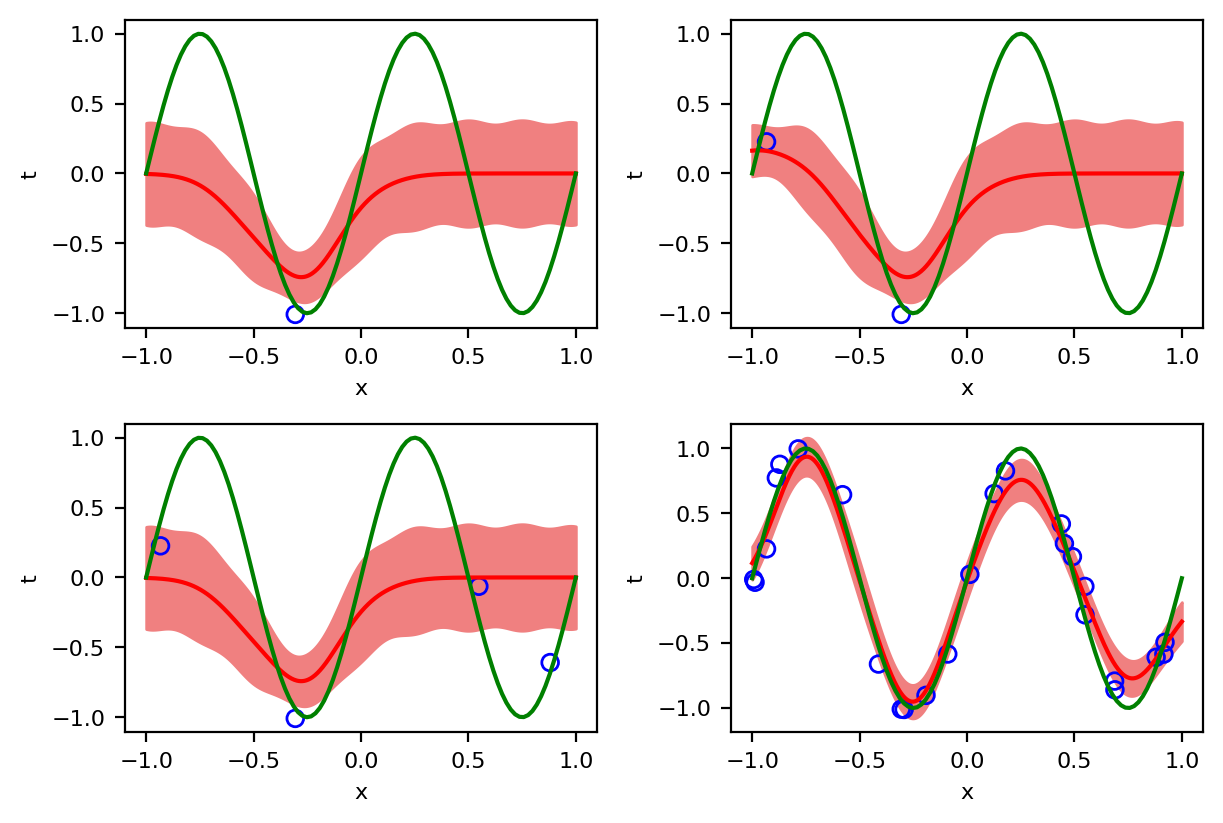

In [175]:

# start with some arbitrary precision parameter for the prior
alpha = 4

# choose an initial mean and precision matrix for the weights prior
m_0 = np.zeros(9)
s_0_inv = alpha*np.eye(9)

post_1 = form_post(x[0:1], t[0:1], s_0_inv, beta)
post_2 = form_post(x[0:2], t[0:2], s_0_inv, beta)
post_4 = form_post(x[0:4], t[0:4], s_0_inv, beta)
post_25 = form_post(x, t, s_0_inv, beta)

fig, axs = plt.subplots(2, 2, dpi=200, constrained_layout=True) 
plot_38(axs[0,0], post_1, pts[0:1])
plot_38(axs[0,1], post_2, pts[0:2])
plot_38(axs[1,0], post_1, pts[0:4])
plot_38(axs[1,1], post_25, pts)
